## Notebook description
The notebooks contains Vicens Gaitan's [approach](https://www.kaggle.com/vicensgaitan/or-doping) of "Data doping". Complete description of the method can be seen [here](https://indico.cern.ch/event/433556/contributions/1930582/attachments/1230496/1803471/Zurich_MachineLearning_VicensGaitan.pdf)

In [1]:
import os, sys
sys.path.append('utils/')
from evaluation import compute_ks, compute_cvm, roc_auc_truncated
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from tqdm import tqdm

pd.set_option('display.max_columns', 100)
%matplotlib inline

c:\users\artem\anaconda3\envs\lasagne2.7\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('../datasets/training.csv.zip').drop(['production', 'mass', 'min_ANNmuon', 'id'], 1)
agreement = pd.read_csv('../datasets/check_agreement.csv.zip').drop('id', 1)
correlation = pd.read_csv('../datasets/check_correlation.csv.zip').drop('id', 1)
test = pd.read_csv('../datasets/test.csv.zip')
private_dataset = pd.merge(test, pd.read_csv('../datasets/private_eval.csv'), on='id').drop_duplicates().drop('id', 1)
public_dataset = pd.merge(test, pd.read_csv('../datasets/public_eval.csv'), on='id').drop_duplicates().drop('id', 1)
doping = agreement.drop('weight', 1).query('signal == 1')
doping['signal'] = 0
assert set(doping.columns) == set(train.columns), 'columns mismatch: %s' % str(doping.columns.difference(train.columns))
features = train.drop('signal', 1).columns

In [3]:
train.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,DOCAthree,IP_p0p2,IP_p1p2,isolationa,isolationb,isolationc,isolationd,isolatione,isolationf,iso,CDF1,CDF2,CDF3,ISO_SumBDT,p0_IsoBDT,p1_IsoBDT,p2_IsoBDT,p0_track_Chi2Dof,p1_track_Chi2Dof,p2_track_Chi2Dof,p0_IP,p1_IP,p2_IP,p0_IPSig,p1_IPSig,p2_IPSig,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,signal
0,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,0.060602,0.083660,0.208855,0.074343,8,5,7,1.0,0.0,3.0,4.0,0.473952,0.349447,0.329157,-0.579324,-0.256309,-0.215444,-0.107570,1.921700,0.866657,1.230708,0.988054,0.601483,0.277090,16.243183,4.580875,5.939936,353.819733,448.369446,1393.246826,3842.096436,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,0
1,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,0.019245,0.030784,0.336345,0.173161,7,12,2,0.0,1.0,1.0,2.0,0.325785,0.265939,0.192599,-0.873926,-0.223774,-0.224871,-0.425281,0.958776,0.858357,1.810709,0.098752,0.219099,0.614524,3.610463,15.555593,11.238523,656.524902,2033.918701,747.137024,8299.368164,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,0
2,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,0.047947,0.096829,0.169165,0.079789,1,0,1,0.0,0.0,0.0,0.0,1.000000,0.786482,0.557760,-0.479636,-0.202451,-0.100762,-0.176424,0.720973,1.408519,1.038347,0.186143,0.215668,0.371820,4.851371,11.590331,13.723293,658.523743,2576.380615,963.652466,11323.134766,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,0
3,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,0.006417,0.044816,0.050989,0.068167,2,2,4,0.0,0.0,0.0,0.0,1.000000,0.501195,0.501195,-0.439453,-0.162267,-0.176424,-0.100762,1.172767,2.044164,0.811454,0.255752,0.210698,0.392195,7.292110,8.778173,16.462036,1047.216187,1351.734131,1685.003662,11502.081055,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,0
4,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,0.037326,0.019026,0.172065,0.131732,0,2,0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.639926,-0.822285,-0.291524,-0.261078,-0.269682,1.523252,0.435325,0.581312,0.270755,0.183355,0.630763,6.783962,3.342091,17.252840,1442.538208,1755.792236,1282.428711,74117.117188,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,0


In [4]:
agreement.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,DOCAthree,IP_p0p2,IP_p1p2,isolationa,isolationb,isolationc,isolationd,isolatione,isolationf,iso,CDF1,CDF2,CDF3,ISO_SumBDT,p0_IsoBDT,p1_IsoBDT,p2_IsoBDT,p0_track_Chi2Dof,p1_track_Chi2Dof,p2_track_Chi2Dof,p0_IP,p1_IP,p2_IP,p0_IPSig,p1_IPSig,p2_IPSig,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,signal,weight
0,0.001451,0.999964,6.945030,0.229196,0.058117,2.961298,7.953543,2251.611816,0.082219,0.084005,0.066887,0.185107,0.214719,8,6,1,2.0,1.0,1.0,4.0,0.732076,0.492269,0.179091,-0.207475,-0.019306,-0.089797,-0.098372,0.606178,0.862549,1.487057,0.483199,0.474925,0.426797,24.701061,10.732132,8.853514,1438.064697,468.645721,834.562378,10392.814453,6380.673828,15195.594727,2.666142,3.302978,3.594246,512,0,-0.307813
1,0.000679,0.999818,9.468235,0.517488,0.189683,14.413060,7.141451,10594.470703,0.007983,0.044154,0.001321,0.039357,0.217507,5,6,17,1.0,1.0,1.0,3.0,0.802508,0.605835,0.584701,-0.659644,-0.278330,-0.186370,-0.194944,1.900118,1.073474,1.336784,0.712242,0.260311,0.123877,11.312134,16.435398,7.737038,316.791351,7547.703613,2861.309814,3174.356934,64480.023438,23134.953125,2.995265,2.834816,2.779366,552,0,-0.331421
2,0.003027,0.999847,13.280714,0.219291,0.231709,11.973175,4.778880,2502.196289,0.045085,0.106614,0.005850,0.335788,0.885080,2,2,1,0.0,0.0,1.0,1.0,0.682607,0.682607,0.295038,-0.399239,-0.115879,-0.131069,-0.152291,0.660675,1.683084,0.798658,0.381544,1.163556,1.290409,16.435801,20.686119,44.521961,1887.477905,317.579529,932.128235,15219.761719,3921.181641,10180.791016,2.776633,3.204923,3.081832,318,0,-0.382215
3,0.000810,0.999998,5.166821,0.167886,0.011298,0.891142,5.528002,5097.813965,0.055115,0.038642,0.003864,0.076522,0.068347,4,4,3,0.0,0.0,0.0,0.0,0.533615,0.533615,0.533615,-0.821041,-0.208248,-0.177802,-0.434991,0.770563,1.093031,0.938619,0.564650,0.164411,0.166646,24.878387,7.873435,9.630725,975.041687,1650.837524,2617.248291,4365.082520,13221.149414,24291.875000,2.179345,2.769762,2.918251,290,0,1.465194
4,0.000706,0.999896,10.897236,0.284975,0.160511,16.367550,8.670339,20388.097656,0.015587,0.020872,0.014612,0.249906,0.139937,0,1,0,0.0,0.0,0.0,0.0,0.926410,0.926410,0.926410,-1.116815,-0.328938,-0.443564,-0.344313,1.080559,1.471946,1.123868,0.373736,0.230584,0.112430,28.557213,18.738485,7.389726,6035.000977,9657.492188,4763.682617,27463.011719,46903.394531,24241.628906,2.196114,2.262732,2.310401,45,0,-0.477084


In [5]:
correlation.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,DOCAthree,IP_p0p2,IP_p1p2,isolationa,isolationb,isolationc,isolationd,isolatione,isolationf,iso,CDF1,CDF2,CDF3,ISO_SumBDT,p0_IsoBDT,p1_IsoBDT,p2_IsoBDT,p0_track_Chi2Dof,p1_track_Chi2Dof,p2_track_Chi2Dof,p0_IP,p1_IP,p2_IP,p0_IPSig,p1_IPSig,p2_IPSig,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,mass
0,0.000703,0.999715,2.927074,0.214014,0.081302,4.259793,1.066585,3108.189941,0.010767,0.024147,0.003066,0.100619,0.087596,2,10,5,2.0,1.0,1.0,4.0,0.661286,0.592280,0.592280,-0.229346,-0.089797,-0.049752,-0.089797,1.015762,0.918588,2.555963,0.336053,0.138520,0.239775,6.975648,7.199831,9.638602,1142.124512,1294.450928,1073.976440,9274.671875,7963.914062,6712.897949,2.783731,2.503310,2.519349,280,1723.887939
1,0.000601,0.999950,15.849142,0.842973,0.182213,13.882857,5.780046,6858.264648,0.007574,0.020010,0.064194,0.058354,0.247012,3,3,4,0.0,1.0,1.0,2.0,0.744360,0.441476,0.209664,-0.364786,-0.115879,-0.124454,-0.124454,1.413934,0.696266,1.531379,0.282444,0.298322,0.168395,10.620588,17.345636,7.344349,1174.860229,3981.284912,1859.680542,22844.791016,109955.101562,37051.800781,3.660059,4.011287,3.684429,386,1926.284058
2,0.002009,0.999984,43.358494,1.323199,0.200158,12.870687,3.460782,3604.347412,0.052849,0.127547,0.073476,0.365799,0.292673,0,1,0,0.0,0.0,0.0,0.0,0.699672,0.678214,0.437321,-1.175178,-0.351104,-0.414748,-0.409326,1.307686,1.081815,0.674668,0.173122,0.480514,1.041596,4.409735,30.871080,7.409998,1046.867310,2564.430420,354.095032,45214.070312,77265.429688,12087.007812,4.458619,4.098382,4.223254,433,1830.873047
3,0.001268,0.999550,6.910733,0.198652,0.167730,8.559438,7.676139,3240.960449,0.101368,0.002148,0.037449,0.060147,0.162985,4,9,4,1.0,1.0,1.0,3.0,0.257655,0.184313,0.182857,-0.495822,-0.194944,-0.176424,-0.124454,1.019122,2.248540,1.243463,0.390963,0.627191,0.136959,11.687304,31.343948,4.312659,1051.328979,1178.332031,1285.701660,11245.551758,6770.969238,17003.119141,3.060873,2.434033,3.273807,245,1909.119019
4,0.001937,0.999996,36.135208,0.508036,0.097170,9.295684,0.426340,6448.445312,0.007005,0.008510,0.009841,0.481759,0.455559,0,4,0,0.0,0.0,0.0,0.0,0.588020,0.537217,0.222616,-0.766796,-0.263475,-0.263475,-0.239847,0.766173,0.715839,0.847636,0.612008,0.498065,0.641609,38.172073,38.144756,14.099512,3081.089111,3140.512207,385.343475,48171.457031,43973.835938,7368.522949,3.441606,3.331079,3.643300,489,1600.925049


In [6]:
doping.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,DOCAthree,IP_p0p2,IP_p1p2,isolationa,isolationb,isolationc,isolationd,isolatione,isolationf,iso,CDF1,CDF2,CDF3,ISO_SumBDT,p0_IsoBDT,p1_IsoBDT,p2_IsoBDT,p0_track_Chi2Dof,p1_track_Chi2Dof,p2_track_Chi2Dof,p0_IP,p1_IP,p2_IP,p0_IPSig,p1_IPSig,p2_IPSig,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,signal
322942,0.001168,1.000000,32.770912,1.116541,0.019252,1.609411,1.026407,6958.095215,0.023566,0.038159,0.009742,0.334570,0.097510,0,9,1,0.0,0.0,0.0,0.0,0.849071,0.636435,0.348339,-0.619964,-0.343279,-0.086091,-0.190595,0.888392,0.651335,1.664035,0.754793,0.115148,0.434611,21.860670,9.222188,7.182562,917.388611,5367.883789,885.319153,24313.054688,130735.593750,30629.277344,3.970029,3.885469,4.236701,562,0
322943,0.002049,0.999668,11.172977,0.213879,0.291120,14.969730,12.139572,2906.387451,0.126695,0.017756,0.014692,0.498874,0.409349,1,1,2,0.0,0.0,1.0,1.0,0.356380,0.356380,0.345954,-0.688046,-0.256309,-0.260895,-0.170842,0.855026,0.704649,0.936754,0.553817,0.822781,0.790170,15.682039,23.990385,38.443085,1295.471069,658.196411,1340.785522,20273.212891,5583.947266,10117.930664,3.442551,2.827803,2.709781,163,0
322944,0.002262,1.000000,80.662674,1.105964,0.024283,1.194230,5.195050,6945.611816,0.052297,0.059559,0.003258,0.234517,0.303150,0,0,0,0.0,0.0,0.0,0.0,0.833708,0.791855,0.700277,-1.428467,-0.466572,-0.531661,-0.430234,1.036300,1.796137,1.019913,1.046214,0.344323,0.654252,45.127884,10.144923,18.038975,1993.841553,2455.240234,2654.510498,49692.945312,94529.859375,89763.476562,3.908544,4.343669,4.213846,245,0
322945,0.000657,0.999962,5.286009,0.253413,0.046866,3.967474,5.474593,3805.479980,0.013582,0.064476,0.024219,0.068384,0.118381,8,15,7,1.0,1.0,0.0,2.0,0.267858,0.194425,0.186358,-0.189301,-0.049752,-0.120243,-0.019306,1.118179,0.901694,1.119812,0.261138,0.437650,0.134893,9.321936,14.657409,8.871321,926.702271,537.432373,2627.658936,14102.780273,3366.317383,35374.738281,3.414561,2.521485,3.291670,187,0
322946,0.002075,0.999765,9.002613,0.168594,0.184490,15.181608,13.018804,3272.299805,0.046251,0.046957,0.071348,0.491743,0.275727,8,7,19,2.0,2.0,0.0,4.0,0.254169,0.169464,0.147767,-0.457421,-0.155172,-0.186370,-0.115879,1.186048,1.303239,0.922157,0.824597,0.604251,0.366459,38.354759,27.798504,23.006224,1177.186279,1049.002441,1550.444580,7903.222656,9631.545898,11243.642578,2.591697,2.907372,2.669620,295,0


In [7]:
DOPING_SIZE = 3960
doping_train, doping_test = train_test_split(
    pd.concat([train, doping.sample(DOPING_SIZE)]).sample(frac=1.).reset_index(drop=True), train_size=0.8)
doping_train.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,DOCAthree,IP_p0p2,IP_p1p2,isolationa,isolationb,isolationc,isolationd,isolatione,isolationf,iso,CDF1,CDF2,CDF3,ISO_SumBDT,p0_IsoBDT,p1_IsoBDT,p2_IsoBDT,p0_track_Chi2Dof,p1_track_Chi2Dof,p2_track_Chi2Dof,p0_IP,p1_IP,p2_IP,p0_IPSig,p1_IPSig,p2_IPSig,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,signal
37921,0.001850,0.999997,15.083743,0.292075,0.036173,1.762079,1.449024,3653.789307,0.000660,0.043599,0.000360,0.425800,0.188993,0,3,4,0.0,0.0,0.0,0.0,0.316776,0.310716,0.283097,-0.884870,-0.314519,-0.413770,-0.156581,1.238105,1.069824,1.321850,0.848262,0.465272,0.323157,43.177372,11.218772,12.814080,1153.632446,1233.874512,1573.723633,11548.803711,24376.648438,17582.718750,2.994309,3.675972,3.104610,329,0
21846,0.000940,0.999949,9.831983,0.265464,0.100923,9.018113,6.883447,6857.316406,0.008905,0.004852,0.021912,0.141105,0.125619,8,8,5,3.0,3.0,2.0,8.0,0.498861,0.400905,0.196653,-0.316439,-0.115879,-0.115879,-0.084681,0.831668,0.837367,1.490231,0.318662,0.167781,0.386332,19.743166,11.587450,24.118380,2381.194824,2833.001465,1706.299805,17212.564453,21276.453125,19668.742188,2.666365,2.704949,3.135964,428,0
12608,0.000971,0.999328,8.129383,0.553595,0.235907,9.946823,12.625285,1891.709229,0.107651,0.041061,0.112745,0.397616,0.196183,1,2,2,0.0,1.0,0.0,1.0,0.805571,0.805571,0.696557,-0.839087,-0.157545,-0.248440,-0.433102,1.274024,0.575253,0.905764,0.609840,0.175416,0.294911,16.109106,6.126027,5.093707,461.165710,1104.363281,739.900879,5142.798828,29178.816406,11304.649414,3.102726,3.966963,3.418528,153,0
26603,0.001553,0.999998,15.874619,0.249683,0.028068,1.949115,2.740091,3546.542236,0.005230,0.037797,0.044054,0.177296,0.132419,2,1,1,0.0,0.0,0.0,0.0,0.664477,0.536879,0.521668,-0.954781,-0.346985,-0.362611,-0.245184,0.794899,1.163445,1.112548,1.701074,0.150877,0.111767,48.211113,8.453272,4.545065,646.428284,1772.876221,1127.885620,3910.094971,35546.578125,21460.798828,2.486098,3.690765,3.638339,265,1
57553,0.001852,0.999981,9.067086,0.172479,0.055131,3.904294,3.775802,4605.531738,0.001250,0.032361,0.030908,0.238453,0.300857,0,0,0,0.0,0.0,0.0,0.0,0.890923,0.890923,0.890923,-1.318992,-0.528970,-0.395011,-0.395011,1.003483,0.813631,0.853834,0.783368,0.154943,0.726130,30.731298,7.426782,26.425621,1622.355591,2366.192383,920.087280,8801.612305,15005.850586,5198.835938,2.375599,2.534030,2.416945,71,1


In [10]:
def cross_validation(model):
    agreement_probs = model.predict_proba(agreement[features])[:, 1]
    correlation_probs = model.predict_proba(correlation[features])[:, 1]
    auc_holdout = roc_auc_truncated(doping_test.signal, model.predict_proba(doping_test[features])[:, 1])
    auc_private = roc_auc_truncated(private_dataset.signal, model.predict_proba(private_dataset[features])[:, 1])
    auc_public = roc_auc_truncated(public_dataset.signal, model.predict_proba(public_dataset[features])[:, 1])
    ks = compute_ks(agreement_probs[agreement.signal == 0],
        agreement_probs[agreement.signal == 1],
        agreement.query('signal == 0')['weight'].values,
        agreement.query('signal == 1')['weight'].values)
    cvm = compute_cvm(correlation_probs, correlation.mass.values)
    return auc_holdout, auc_public, auc_private, ks, cvm

def print_metrics(model):
    auc_holdout, auc_public, auc_private, ks, cvm = cross_validation_dann(model)
    ks_threshold = 0.09
    cvm_threshold = 0.002
    print('AUC (holdout): %.3f' % auc_holdout)
    print('AUC (public leaderboard): %.3f' % auc_public)
    print('AUC (private leaderboard): %.3f' % auc_private)
    print('[%s] KS: %.2f (threshold %.2f)' % ('SUCCESS' if ks < ks_threshold else 'FAILED', ks, ks_threshold))
    print('[%s] CvM: %.4f (threshold %.3f)' % ('SUCCESS' if cvm < cvm_threshold else 'FAILED', cvm, cvm_threshold))

In [15]:
estimators = range(10, 200, 10)
aucs_holdout = []
aucs_private = []
aucs_public = []
kss = []
cvms = []
for n_estimators in tqdm(estimators):
    clf = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric='auc', max_depth=5, 
                            eta=.05, n_estimators=n_estimators)
    clf.fit(doping_train[features], doping_train.signal)
    auc_holdout, auc_public, auc_private, ks, cvm = cross_validation(clf)
    aucs_holdout.append(auc_holdout); aucs_private.append(auc_private); aucs_public.append(auc_public); kss.append(ks); cvms.append(cvm)

100%|██████████| 19/19 [13:44<00:00, 67.95s/it]


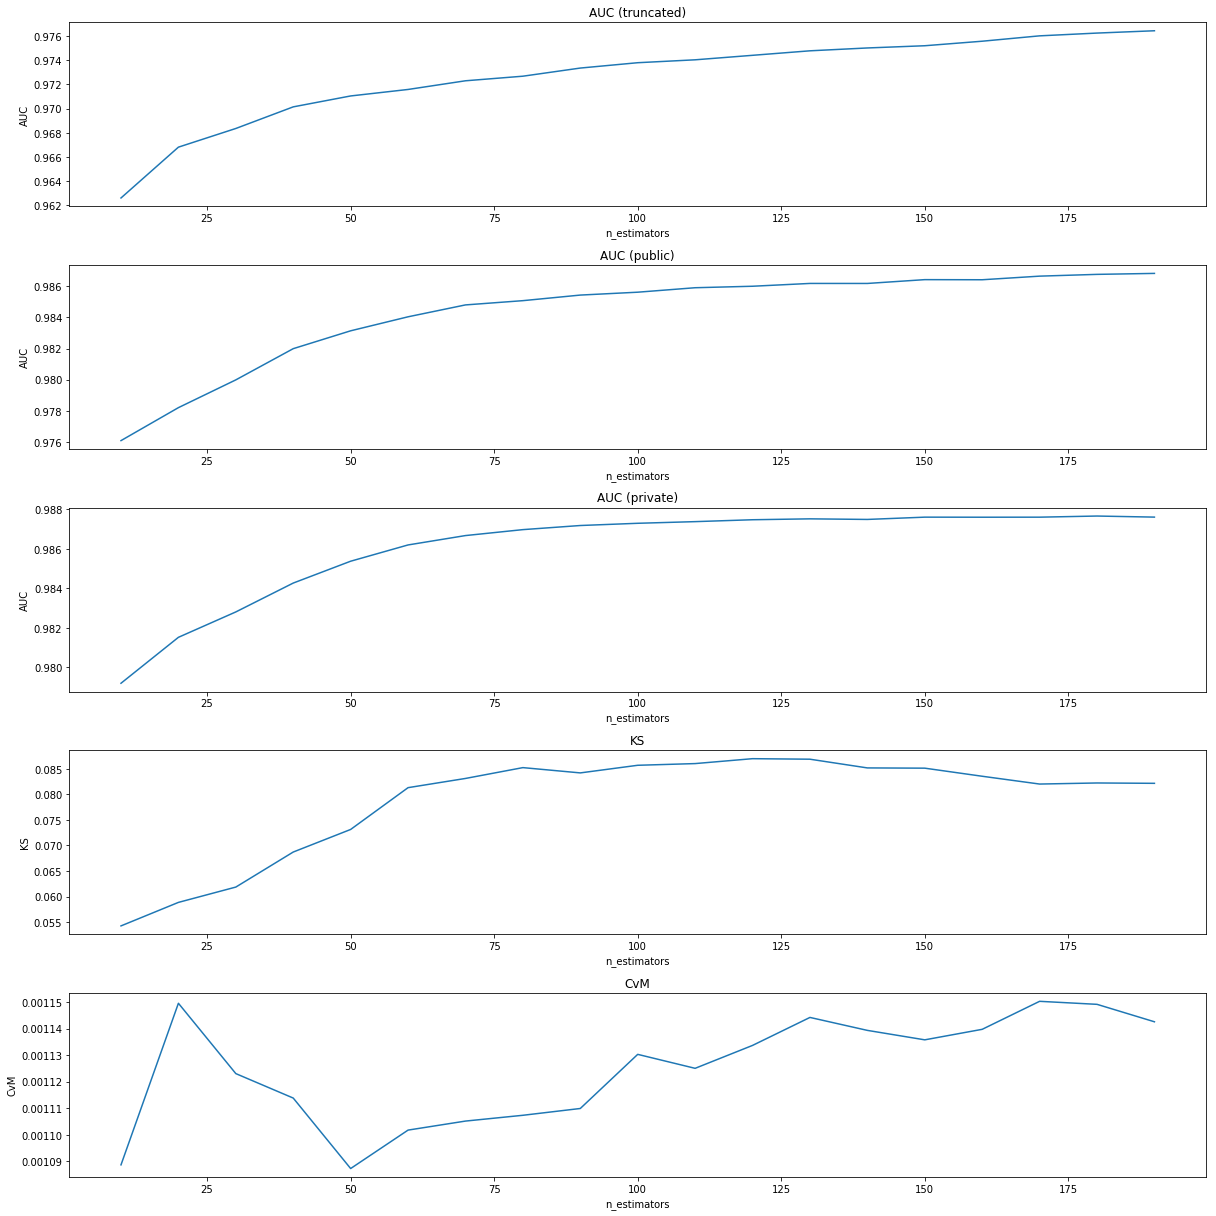

In [16]:
plt.figure(figsize=(17, 17))
plt.subplot(511)
plt.title('AUC (truncated)')
plt.ylabel('AUC')
plt.xlabel('n_estimators')
plt.plot(estimators, aucs_holdout)

plt.subplot(512)
plt.title('AUC (public)')
plt.ylabel('AUC')
plt.xlabel('n_estimators')
plt.plot(estimators, aucs_public)

plt.subplot(513)
plt.title('AUC (private)')
plt.ylabel('AUC')
plt.xlabel('n_estimators')
plt.plot(estimators, aucs_private)

plt.subplot(514)
plt.title('KS')
plt.ylabel('KS')
plt.xlabel('n_estimators')
plt.plot(estimators, kss)

plt.subplot(515)
plt.title('CvM')
plt.ylabel('CvM')
plt.xlabel('n_estimators')
plt.plot(estimators, cvms)


plt.tight_layout();

Visually, the best result is at "n_estimators=120" point. Let's see

In [17]:
'n_estimators: %d, AUC (truncated): %.4f, KS: %.4f, CvM: %.5f' % filter(lambda x: x[0] == 120, zip(estimators, aucs_holdout, kss, cvms))[0]

'n_estimators: 120, AUC (truncated): 0.9744, KS: 0.0870, CvM: 0.00113'